#### 1- Import libs

In [ ]:
import tensorflow as tf
import numpy as np 
import librosa
import pandas as pd
import os 
import matplotlib.pyplot as plt
import soundfile as sf
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
CV_PATH = '/kaggle/input/common-voice/cv-valid-train/cv-valid-train'
RC_PATH = '/kaggle/input/audio-dataset-1-robocall-dataset/audio-wav/audio-wav-16khz'

In [4]:
cv_files = [os.path.join(CV_PATH,file)  for file in os.listdir(CV_PATH) if file.endswith('.mp3')]
rc_files = [os.path.join(RC_PATH,file) for file in os.listdir(RC_PATH) if file.endswith('.wav')]

In [ ]:
# the first 1442 samples to balanced data and low power consumption
cv_files = cv_files[:1442]

In [6]:
cv_metadata = [{'file_path': file, 'label':0} for file in cv_files]
rc_metadata = [{'file_path': file, 'label':1} for file in rc_files]


In [7]:
cv_files[:5]

['/kaggle/input/common-voice/cv-valid-train/cv-valid-train/sample-190523.mp3',
 '/kaggle/input/common-voice/cv-valid-train/cv-valid-train/sample-134671.mp3',
 '/kaggle/input/common-voice/cv-valid-train/cv-valid-train/sample-136900.mp3',
 '/kaggle/input/common-voice/cv-valid-train/cv-valid-train/sample-087521.mp3',
 '/kaggle/input/common-voice/cv-valid-train/cv-valid-train/sample-141316.mp3']

In [8]:
rc_files[:5]

['/kaggle/input/audio-dataset-1-robocall-dataset/audio-wav/audio-wav-16khz/739583_normalized.wav',
 '/kaggle/input/audio-dataset-1-robocall-dataset/audio-wav/audio-wav-16khz/520014_normalized.wav',
 '/kaggle/input/audio-dataset-1-robocall-dataset/audio-wav/audio-wav-16khz/447375_normalized.wav',
 '/kaggle/input/audio-dataset-1-robocall-dataset/audio-wav/audio-wav-16khz/383719_normalized.wav',
 '/kaggle/input/audio-dataset-1-robocall-dataset/audio-wav/audio-wav-16khz/307201_normalized.wav']

In [9]:
rc_metadata[:3]

[{'file_path': '/kaggle/input/audio-dataset-1-robocall-dataset/audio-wav/audio-wav-16khz/739583_normalized.wav',
  'label': 1},
 {'file_path': '/kaggle/input/audio-dataset-1-robocall-dataset/audio-wav/audio-wav-16khz/520014_normalized.wav',
  'label': 1},
 {'file_path': '/kaggle/input/audio-dataset-1-robocall-dataset/audio-wav/audio-wav-16khz/447375_normalized.wav',
  'label': 1}]

In [10]:
cv_metadata[:3]

[{'file_path': '/kaggle/input/common-voice/cv-valid-train/cv-valid-train/sample-190523.mp3',
  'label': 0},
 {'file_path': '/kaggle/input/common-voice/cv-valid-train/cv-valid-train/sample-134671.mp3',
  'label': 0},
 {'file_path': '/kaggle/input/common-voice/cv-valid-train/cv-valid-train/sample-136900.mp3',
  'label': 0}]

##### 2- compined the legtimite and robocalls

In [ ]:
compined_metadata = cv_metadata + rc_metadata
df = pd.DataFrame(compined_metadata)

#### 3- EDA for compined

In [12]:
df.head()

,file_path,label
0,/kaggle/input/common-voice/cv-valid-train/cv-v...,0
1,/kaggle/input/common-voice/cv-valid-train/cv-v...,0
2,/kaggle/input/common-voice/cv-valid-train/cv-v...,0
3,/kaggle/input/common-voice/cv-valid-train/cv-v...,0
4,/kaggle/input/common-voice/cv-valid-train/cv-v...,0


In [13]:
df.tail()

,file_path,label
2810,/kaggle/input/audio-dataset-1-robocall-dataset...,1
2811,/kaggle/input/audio-dataset-1-robocall-dataset...,1
2812,/kaggle/input/audio-dataset-1-robocall-dataset...,1
2813,/kaggle/input/audio-dataset-1-robocall-dataset...,1
2814,/kaggle/input/audio-dataset-1-robocall-dataset...,1


In [14]:
len(rc_metadata)

1373

In [15]:
len(cv_metadata)

1442

#### 4- Split for train and test

In [16]:
train_df, test_df = train_test_split(df,stratify = df['label'], test_size = 0.2, random_state = 42)

In [17]:
check_test_division = test_df['label'].value_counts()
check_test_division

label
0    288
1    275
Name: count, dtype: int64

In [18]:
check_train_division = train_df['label'].value_counts()
check_train_division

label
0    1154
1    1098
Name: count, dtype: int64

#### 5- Feature extrtacation using spectrogram

In [19]:
def extract_spectrogram(file_path, max_length=16000 * 5):
    # تحميل الصوت
    audio, sr = librosa.load(file_path, sr=16000)

    if len(audio) > max_length:
        audio = audio[:max_length]
    else:
        audio = np.pad(audio, (0, max_length - len(audio)), "constant")

    S = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=128)
    S_db = librosa.power_to_db(S, ref=np.max)

    return S_db

def prepare_data(df):
    X = []
    y = []
    for _, row in df.iterrows():
        spectrogram = extract_spectrogram(row["file_path"])
        X.append(spectrogram)
        y.append(row["label"])
    return np.array(X), np.array(y)

X_train, y_train = prepare_data(train_df)
X_test, y_test = prepare_data(test_df)

X_train = X_train[..., np.newaxis]
X_test = X_test[..., np.newaxis]

#### 6- Building the CNN

In [ ]:
# CNN 
model = models.Sequential([
    layers.Input(shape=(X_train.shape[1], X_train.shape[2], 1)),
    layers.Conv2D(32, (3, 3), activation="relu", padding="same"),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation="relu", padding="same"),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation="relu", padding="same"),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(1, activation="sigmoid")  # (Robocall/Non-Robocall)
])

model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 128, 157, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 64, 78, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 64, 78, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 32, 39, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 32, 39, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 16, 19, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 38912)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       4,980,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,073,665 (19.35 MB)

 Trainable params: 5,073,665 (19.35 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 9s 59ms/step - accuracy: 0.7223 - loss: 10.9286 - val_accuracy: 0.9627 - val_loss: 0.1189
Epoch 2/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9620 - loss: 0.1319 - val_accuracy: 0.9698 - val_loss: 0.0925
Epoch 3/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9649 - loss: 0.0819 - val_accuracy: 0.9787 - val_loss: 0.0496
Epoch 4/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9797 - loss: 0.0662 - val_accuracy: 0.9840 - val_loss: 0.0520
Epoch 5/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9304 - loss: 0.2134 - val_accuracy: 0.9591 - val_loss: 0.1523
Epoch 6/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9772 - loss: 0.0787 - val_accuracy: 0.9858 - val_loss: 0.0372
Epoch 7/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9859 - loss: 0.0364 - val_accuracy: 0.9858 - val_loss: 0.0399
Epoch 8/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9912 - loss: 0.0236 - val_accuracy: 0.9716 - 

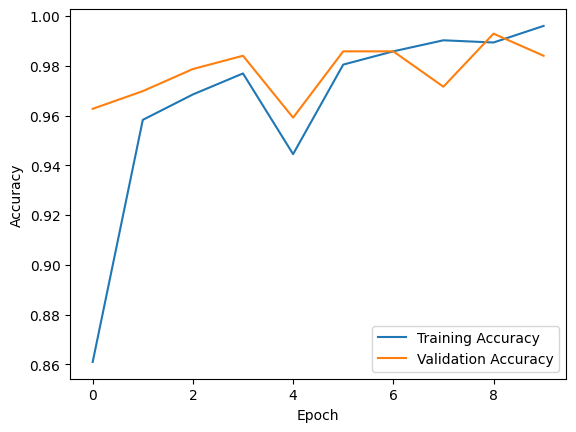

In [ ]:
#Train the CNN
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

# plot the acc of train and valid subsets
plt.plot(history.history["accuracy"], label="Training Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [ ]:
# test new sample
test_file = '/kaggle/input/common-voice/cv-invalid/cv-invalid/sample-000955.mp3'
spectrogram = extract_spectrogram(test_file)
spectrogram = spectrogram[np.newaxis, ..., np.newaxis]  # إضافة أبعاد للتنبؤ

# التنبؤ
prediction = model.predict(spectrogram)
label = "Robocall" if prediction[0] > 0.5 else "Non-Robocall"
print(f"Prediction: {label}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 503ms/step
Prediction: Non-Robocall


In [23]:
model.save("/kaggle/working/robocall_classifier.h5")
print('saved model')

saved model
